In [9]:
pip install yfinance --upgrade --no-cache-dir

     ---------------------------------------- 73.5/73.5 kB 1.0 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 6.4 MB/s eta 0:00:00
     -------------------------------------- 505.5/505.5 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 64.9/64.9 kB ? eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.5-py3-none-any.whl size=138681 sha256=a666a266e52dc14740960f050b79dd5b4cd0b392b058757ceb1d0488fd6769f2
  Stored in directory: C:\Users\pocot\AppData\Local\Temp\pip-ephem-wheel-cache-txwa6m9f\wheels\95\bd\4e\15d1893c245357e4d2353e

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.32.3 which is incompatible.


In [290]:
import yfinance as yf
import pandas as pd
import json



def load_tickers_and_dates(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
        tickers = [stock['symbol'] for stock in data['stocks']]
        start_date = data['start_date']
        end_date = data['end_date']
    return tickers, start_date, end_date



def fetch_and_prepare_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    if stock_data.isnull().values.any():
        stock_data = stock_data.fillna(method='ffill')
    features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
    stock_data['Ticker'] = symbol  
    return stock_data.dropna()



if __name__ == "__main__":
    json_file_path = 'tickers.json'  
    tickers, start_date, end_date = load_tickers_and_dates(json_file_path)

    all_stocks_data = pd.DataFrame()  

    for symbol in tickers:
        print(f"Fetching data for {symbol}...")
        stock_data = fetch_and_prepare_stock_data(symbol, start_date, end_date)
        all_stocks_data = pd.concat([all_stocks_data, stock_data])  


    all_stocks_data.to_csv('all_stocks_data.csv', index=True)

Fetching data for AAPL...


[*********************100%%**********************]  1 of 1 completed


In [291]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
from itertools import product

In [404]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


stock_data = pd.read_csv('all_stocks_data.csv')


data = stock_data['Close'].values.reshape(-1, 1)


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


time_step = 100
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0],X.shape[1] , 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(100, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


model.save('model.h5')


Epoch 1/100
12/12 [==============================] - 4s 103ms/step - loss: 0.0819 - val_loss: 0.0070
Epoch 2/100
12/12 [==============================] - 1s 65ms/step - loss: 0.0135 - val_loss: 0.0059
Epoch 3/100
12/12 [==============================] - 1s 65ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 4/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 5/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0014 - val_loss: 0.001

12/12 [==============================] - 1s 62ms/step - loss: 6.3597e-04 - val_loss: 6.7292e-04
Epoch 80/100
12/12 [==============================] - 1s 59ms/step - loss: 6.8680e-04 - val_loss: 7.4934e-04
Epoch 81/100
12/12 [==============================] - 1s 60ms/step - loss: 6.1733e-04 - val_loss: 7.1929e-04
Epoch 82/100
12/12 [==============================] - 1s 59ms/step - loss: 6.4515e-04 - val_loss: 6.3627e-04
Epoch 83/100
12/12 [==============================] - 1s 59ms/step - loss: 5.6154e-04 - val_loss: 6.5093e-04
Epoch 84/100
12/12 [==============================] - 1s 59ms/step - loss: 5.5505e-04 - val_loss: 6.3266e-04
Epoch 85/100
12/12 [==============================] - 1s 59ms/step - loss: 5.5464e-04 - val_loss: 7.0120e-04
Epoch 86/100
12/12 [==============================] - 1s 59ms/step - loss: 5.6486e-04 - val_loss: 6.3998e-04
Epoch 87/100
12/12 [==============================] - 1s 60ms/step - loss: 5.7038e-04 - val_loss: 6.1539e-04
Epoch 88/100
12/12 [============

In [405]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [406]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [407]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_model(model):

    fig, ax = plt.subplots(figsize=(12, 8))


    layer_colors = {
        'LSTM': 'skyblue',
        'Dense': 'lightgreen'
    }


    layer_x = 0
    layer_width = 1.5
    layer_gap = 1.0
    y_center = 5


    for layer in model.layers:
        layer_type = layer.__class__.__name__
        layer_color = layer_colors.get(layer_type, 'lightgrey')
        

        output_shape = layer.output_shape
        if isinstance(output_shape, tuple) and len(output_shape) > 0:
            layer_height = output_shape[-1] / 10.0  
        else:
            layer_height = 1  


        ax.add_patch(Rectangle((layer_x, y_center - layer_height / 2), layer_width, layer_height, edgecolor='black', facecolor=layer_color))


        ax.text(layer_x + layer_width / 2, y_center + layer_height / 2 + 0.1, layer_type, ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.text(layer_x + layer_width / 2, y_center - layer_height / 2 - 0.1, f"Output: {output_shape}", ha='center', va='top', fontsize=10)


        layer_x += layer_width + layer_gap


    ax.set_xlim(-1, layer_x)
    ax.set_ylim(y_center - 10, y_center + 10)
    ax.axis('off')
    plt.title("Model Architecture")
    plt.show()

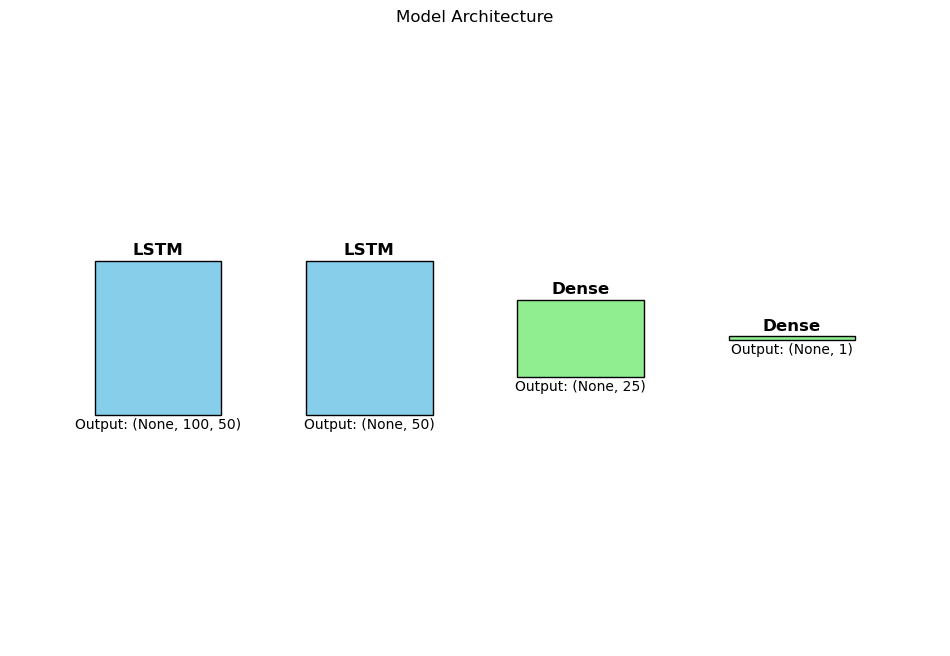

In [408]:
visualize_model(model)

In [409]:

def predict_stock_price(ticker, days_to_predict):

    model = tf.keras.models.load_model('model.h5')


    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale



In [410]:
def predict_stock_price_bullish(ticker, days_to_predict, randomness=0.01):
    # Fetch historical stock data
    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))

        prediction = prediction + (np.random.rand() * randomness)
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale

In [413]:
def predict_stock_price_bearish(ticker, days_to_predict, randomness=0.01):

    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))

        prediction = prediction - (np.random.rand() * randomness)
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale

In [ ]:
def generate_predictions(tickers, days_to_predict, randomness=0.01):
    predictions = {}
    for ticker in tickers:
        bullish_price = predict_stock_price_bullish(ticker, days_to_predict, randomness)[-1, 0]
        bearish_price = predict_stock_price_bearish(ticker, days_to_predict, randomness)[-1, 0]
        current_price = yf.Ticker(ticker).history(period='1d')['Close'][0]
        predicted_price = predict_stock_price(ticker, days_to_predict)[-1, 0]
        predictions[ticker] = [bullish_price, bearish_price, current_price, predicted_price]
    return predictions

In [ ]:
def calculate_percent_change(predictions):
    percent_changes = {}
    for ticker, prices in predictions.items():
        bullish_price, bearish_price, current_price, predicted_price = prices
        bullish_change = ((bullish_price - current_price) / current_price) * 100
        bearish_change = ((bearish_price - current_price) / current_price) * 100
        predicted_change = ((predicted_price - current_price) / current_price) * 100
        percent_changes[ticker] = [bullish_change, bearish_change, predicted_change]
    return percent_changes

In [ ]:
def stock_selection(percent_changes, allowable_change):
    selected_stocks = {}
    for ticker, changes in percent_changes.items():
        bullish_change, bearish_change, predicted_change = changes
        if bullish_change >= allowable_change and bearish_change >= allowable_change and predicted_change >= allowable_change:
            selected_stocks[ticker] = changes
    return selected_stocks

In [ ]:
#heurystyki wybierania portfolio:

In [ ]:
def greedy(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss):
    num_shares = [0] * len(tickers)
    remaining_budget = investment_budget
    remaining_allowable_loss = biggest_allowable_net_loss
    total_invested = 0
    total_loss = 0


    potential_gains = {tickers[i]: scenario[i] - current_prices[i] for i in range(len(tickers))}


    sorted_stocks = sorted(potential_gains.items(), key=lambda item: item[1], reverse=True)

    for ticker, gain in sorted_stocks:
        index = tickers.index(ticker)
        current_price = current_prices[index]
        predicted_price = scenario[index]


        max_shares_by_budget = remaining_budget // current_price
        max_shares_by_loss = remaining_allowable_loss // max(1, current_price - predicted_price)
        max_shares = min(max_shares_by_budget, max_shares_by_loss)

        if max_shares > 0:
            num_shares[index] = max_shares
            invested_amount = max_shares * current_price
            total_invested += invested_amount
            if predicted_price < current_price:
                total_loss += max_shares * (current_price - predicted_price)
            remaining_budget -= invested_amount
            remaining_allowable_loss -= invested_amount

    return num_shares, total_invested, total_loss

In [ ]:
import random
import math

def simulated_annealing(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss, initial_temperature, cooling_rate, num_iterations):
    num_shares = [0] * len(tickers)
    best_shares = list(num_shares)
    remaining_budget = investment_budget
    remaining_allowable_loss = biggest_allowable_net_loss
    total_invested = 0
    total_loss = 0


    def calculate_investment_and_loss(num_shares):
        total_invested = 0
        total_loss = 0
        for i, shares in enumerate(num_shares):
            current_price = current_prices[i]
            predicted_price = scenario[i]
            total_invested += shares * current_price
            if predicted_price < current_price:
                total_loss += shares * (current_price - predicted_price)
        return total_invested, total_loss


    for i in range(len(tickers)):
        if remaining_budget >= current_prices[i]:
            max_shares_by_budget = remaining_budget // current_prices[i]
            max_shares_by_loss = remaining_allowable_loss // max(1, current_prices[i] - scenario[i])
            max_shares = min(max_shares_by_budget, max_shares_by_loss)
            num_shares[i] = random.randint(0, max_shares)
            invested_amount = num_shares[i] * current_prices[i]
            total_invested += invested_amount
            remaining_budget -= invested_amount
            if scenario[i] < current_prices[i]:
                total_loss += num_shares[i] * (current_prices[i] - scenario[i])
                remaining_allowable_loss -= num_shares[i] * (current_prices[i] - scenario[i])
    
    best_shares = list(num_shares)
    best_invested, best_loss = calculate_investment_and_loss(best_shares)

    temperature = initial_temperature

    for iteration in range(num_iterations):

        new_shares = list(num_shares)
        i = random.randint(0, len(tickers) - 1)
        if new_shares[i] > 0:
            new_shares[i] -= 1
        else:
            new_shares[i] += 1

        new_invested, new_loss = calculate_investment_and_loss(new_shares)
        if new_invested <= investment_budget and new_loss <= biggest_allowable_net_loss:

            delta = new_loss - total_loss
            if delta < 0 or random.random() < math.exp(-delta / temperature):
                num_shares = new_shares
                total_invested, total_loss = new_invested, new_loss


                if total_loss < best_loss:
                    best_shares = list(num_shares)
                    best_invested, best_loss = total_invested, total_loss


        temperature *= cooling_rate

    return best_shares, best_invested, best_loss

In [ ]:
import numpy as np

def ant_colony_optimization(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss):
    num_ants=10
    num_iterations=100
    alpha=1.0
    beta=2.0
    evaporation_rate=0.5
    Q=100
    
    num_stocks = len(tickers)
    pheromone = np.ones(num_stocks)
    best_solution = None
    best_invested = 0
    best_loss = float('inf')
    
    def fitness(shares):
        total_invested = sum(shares[i] * current_prices[i] for i in range(num_stocks))
        total_loss = sum(shares[i] * max(0, current_prices[i] - scenario[i]) for i in range(num_stocks))
        return total_invested, total_loss

    for _ in range(num_iterations):
        solutions = []
        investments = []
        losses = []

        for _ in range(num_ants):
            remaining_budget = investment_budget
            remaining_allowable_loss = biggest_allowable_net_loss
            shares = [0] * num_stocks
            for _ in range(num_stocks):
                probabilities = [
                    (pheromone[i] ** alpha) * ((scenario[i] - current_prices[i]) ** beta)
                    if remaining_budget >= current_prices[i] and remaining_allowable_loss >= (current_prices[i] - scenario[i])
                    else 0
                    for i in range(num_stocks)
                ]
                probabilities_sum = sum(probabilities)
                if probabilities_sum == 0:
                    break
                probabilities = [p / probabilities_sum for p in probabilities]
                chosen_stock = np.random.choice(num_stocks, p=probabilities)
                max_shares_by_budget = remaining_budget // current_prices[chosen_stock]
                max_shares_by_loss = remaining_allowable_loss // max(1, current_prices[chosen_stock] - scenario[chosen_stock])
                max_shares = min(max_shares_by_budget, max_shares_by_loss)
                if max_shares > 0:
                    shares[chosen_stock] += max_shares
                    remaining_budget -= max_shares * current_prices[chosen_stock]
                    remaining_allowable_loss -= max_shares * (current_prices[chosen_stock] - scenario[chosen_stock])
            
            total_invested, total_loss = fitness(shares)
            solutions.append(shares)
            investments.append(total_invested)
            losses.append(total_loss)

            if total_loss < best_loss and total_invested <= investment_budget:
                best_solution = shares
                best_invested = total_invested
                best_loss = total_loss

        pheromone *= (1 - evaporation_rate)
        for i in range(num_ants):
            for j in range(num_stocks):
                pheromone[j] += Q / (1 + losses[i]) if solutions[i][j] > 0 else 0

    return best_solution, best_invested, best_loss



In [ ]:
def scenario_for_portfolio(portfolio_decision, scenario):
    resulting_values = [portfolio_decision[i] * scenario[i] for i in range(len(portfolio_decision))]
    return resulting_values
    

In [ ]:
def scenarios_for_portfolios(portfolio_decisions, scenarios):

    
    all_results = []
    for portfolio_decision in portfolio_decisions:
        for scenario in scenarios:
            result = scenario_for_portfolio(portfolio_decision, scenario)
            all_results.append(result)
    
    return all_results

In [ ]:
def result_decision(all_results):
    results = []
    for result in all_results:
        sum = 0
        for value in result:
            sum+=value
        results.append(sum)
    return results

In [ ]:
def maximum_regret_decision(decisions, results):
    #najlepszy wynik dla najlepszej decyzji, nie znamy wiec zakładamy bardzo wysoki
    best_val_best_dec = 1000*investment_budget
    regrets=[]
    result = 0
    r = 0
    for decision in decisions:
        max_regret = 0
        for i in range(3):
            regret = best_val_best_dec - results[r]
            if regret >= max_regret:
                max_regret = regret
            i+=1
            r+=1
        regrets.append(max_regret)
    return regrets
        
    

In [ ]:
def best_decision_minmax_regret(decisions, regrets):
    min_max_regret = math.inf
    best_decision = 0
    no_best_decision = 0
    for i in range(len(regrets)):
        if regrets[i] < min_max_regret:
            min_max_regret = regrets[i]
            best_decision = decisions[i]
            
    return best_decision, min_max_regret, i

In [ ]:
def select_tickers(selected_stocks, tickers):
    selected_tickers = [ticker for ticker in tickers if ticker in selected_stocks.keys()]
    return selected_tickers

In [ ]:
def main_function(tickers, days_to_predict, investment_budget, biggest_allowable_net_loss, allowable_stock_risk):
    randomness = 0.015
    predicted_prices = generate_predictions(tickers, days_to_predict, randomness)
    percent_changes = calculate_percent_change(predicted_prices)
    selected_stocks = stock_selection(percent_changes, allowable_stock_risk)
    selected_tickers = select_tickers(selected_stocks,tickers)
    sc_predicted = []
    sc_bullish = []
    sc_bearish = []
    current_prices = []
    for ticker in selected_tickers:
        if ticker in predicted_prices:
            sc_bullish.append(predicted_prices[ticker][0])
            sc_bearish.append(predicted_prices[ticker][1])
            sc_predicted.append(predicted_prices[ticker][3])
            current_prices.append(predicted_prices[ticker][2])
    portfolio_aco_bearish = ant_colony_optimization(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_aco_bullish = ant_colony_optimization(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_aco_predicted = ant_colony_optimization(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_sa_bearish = simulated_annealing(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_sa_bullish = simulated_annealing(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_sa_predicted = simulated_annealing(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_greedy_bearish = greedy(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_greedy_bullish = greedy(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_greedy_predicted = greedy(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    scenarios = [sc_predicted, sc_bullish, sc_bearish]
    portfolio_decisions = [portfolio_aco_bearish[0], portfolio_aco_bullish[0], portfolio_aco_predicted[0], 
                       portfolio_sa_bearish[0], portfolio_sa_bullish[0], portfolio_sa_predicted[0],
                       portfolio_greedy_bearish[0], portfolio_greedy_bullish[0], portfolio_greedy_predicted[0]]
    l = scenarios_for_portfolios(portfolio_decisions, scenarios)
    results = result_decision(l)
    regrets = maximum_regret_decision(portfolio_decisions, results)
    best_decision, regret, i  = best_decision_minmax_regret(portfolio_decisions, regrets)      
    return best_decision, regret, i, selected_tickers, regrets, results, l


In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'TSM', 'BRK-B', 'LLY', 'AVGO', 'NVO', 'TSLA', 'JPM', 'V', 'WMT', 'XOM', 'UNH', 'TCEHY', 'MA', 'ASML', 'PG', 'ORCL', 'COST' ]
days_to_predict = 10
investment_budget = 10000 #in usd
biggest_allowable_net_loss = 1000 # in usd
allowable_stock_risk = -2

In [ ]:
m = main_function(tickers, days_to_predict, investment_budget, biggest_allowable_net_loss, allowable_stock_risk)

In [412]:
print(m)

([0, 2.0, 0, 0, 0, 0, 20.0, 0], 9989702.616516113, 6, ['AAPL', 'AMZN', 'META', 'BRK-B', 'V', 'XOM', 'UNH', 'MA'], [9990177.61126709, 10000000.0, 10000000.0, 9995250.364959717, 9992462.968963623, 9993947.334564209, 9989702.616516113, 9989855.526657104, 9989795.058959961], [9894.99819946289, 9970.775024414062, 9822.388732910156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4773.043190002441, 4799.354064941406, 4749.635040283203, 7573.549766540527, 7616.465667724609, 7537.031036376953, 6084.985076904297, 6124.085662841797, 6052.665435791016, 10328.101287841797, 10402.426391601562, 10297.383483886719, 10173.538360595703, 10246.219497680664, 10144.473342895508, 10234.078338623047, 10306.865325927734, 10204.941040039062], [[0.0, 9894.99819946289, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 9970.775024414062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 9822.388732910156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [20]:
predicted_prices = predict_stock_price('AAPL', 10)
print("Predicted prices for the next 10 days: ", predicted_prices)

predicted_prices_bullish = predict_stock_price_bullish('AAPL', 10)
print("Bullish predicted prices for the next 10 days: ", predicted_prices_bullish)

predicted_prices_bearish = predict_stock_price_bearish('AAPL', 10)
print("Bearish predicted prices for the next 10 days: ", predicted_prices_bearish)



[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step
Predicted prices for the next 10 days:  [[201.64145]
 [203.66263]
 [204.85011]
 [205.58028]
 [206.04456]
 [206.3441 ]
 [206.53458]
 [206.64864]
 [206.70726]
 [206.72525]]


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step
Bullish predicted prices for the next 10 days:  [[202.03212]
 [203.87245]
 [205.07312]
 [206.21953]
 [206.76314]
 [206.91682]
 [207.28305]
 [207.43663]
 [207.51056]
 [207.71947]]


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Bearish predicted prices for the next 10 days:  [[201.36942]
 [203.54143]
 [204.66467]
 [205.37454]
 [205.79703]
 [205.71915]
 [206.06076]
 [206.26508]
 [206.02328]
 [205.81673]]


In [416]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'TSM', 'BRK-B', 'LLY', 'AVGO', 'NVO', 'TSLA', 'JPM', 'V', 'WMT', 'XOM', 'UNH', 'TCEHY', 'MA', 'ASML', 'PG', 'ORCL', 'COST' ]
days_to_predict = 10
randomness = 0.015
predicted_prices = generate_predictions(tickers, days_to_predict, randomness)
print(predicted_prices)

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 13ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 14ms/step
{'AAPL': [213.95032, 210.20804, 214.2899932861328, 211.80746], 'MSFT': [440.94522, 432.50864, 446.3399963378906, 436.17966], 'GOOGL': [175.90591, 171.45625, 175.08999633789062, 173.68323], 'NVDA': [126.243484, 121.62074, 135.5800018310547, 123.76856], 'AMZN': [184.9979, 180.79022, 182.80999755859375, 182.19814], 'META': [507.17828, 486.3136, 499.489990234375, 495.60736], 'TSM': [171.49036, 165.15002, 179.69000244140625, 168.4936], 'BRK-B': [408.94794, 401.44803, 407.95001220703125, 404.82532], 'LLY': [869.94885, 839.6802, 891.4600219726562, 852.73474], 'AVGO': [1695.8003, 1627.4497, 1802.52001953125, 1664.8906], 'NVO': [141.53638, 136.24359, 140.8000030517578, 138.79095], 'TSLA': [182.40918, 174.08609, 184.86000061035156, 179.35393], 'JPM': [194.86636, 190.63614, 197.0, 192.55011], 'V': [273.91522, 269.54764, 273.6199951171875, 271.37753], 'WMT': [66.26916, 65.18217, 67.5999984741211, 65.84828], 'XOM': [111.07707, 109.450714, 109.3799

In [417]:
percent_changes = calculate_percent_change(predicted_prices)
print(percent_changes)

{'AAPL': [-0.15851225627076151, -1.9048742750223606, -1.1584902535362989], 'MSFT': [-1.2086694974431595, -3.0988394445409644, -2.276367665643192], 'GOOGL': [0.4659991923098978, -2.075357451673238, -0.8034546965854786], 'NVDA': [-6.886352860223845, -10.29595725378265, -8.711785923176421], 'AMZN': [1.1968145931484773, -1.1048495255176771, -0.3346984250251823], 'META': [1.5392287347787854, -2.637969100317658, -0.7773187592226641], 'TSM': [-4.563217699753502, -8.091701168563889, -6.230950927653521], 'BRK-B': [0.24461938346040826, -1.5938187150435534, -0.7659504181196085], 'LLY': [-2.413026821549779, -5.808431664364024, -4.344028874791938], 'AVGO': [-5.920584814933303, -9.712530823681364, -7.635387848121702], 'NVO': [0.5229928163399953, -3.2360878156296167, -1.4268809789553343], 'TSLA': [-1.3257713484581286, -5.828145887097673, -2.978509672112677], 'JPM': [-1.0830642003093274, -3.230386337047906, -2.2588274805678936], 'V': [0.10789673856064813, -1.4883258717953867, -0.8195534676633229], 'WM

In [418]:
selected_stocks = stock_selection(percent_changes, -0.5)
print(selected_stocks)

{'XOM': [1.5515404395237244, 0.06465245902897154, 0.8679709458029088], 'UNH': [4.765037163502536, 2.8744888519642715, 3.8292852790000103]}


In [419]:
investment_budget = 10000 #in usd
biggest_allowable_net_loss = 2000 # in usd

In [420]:
#bierzemy pod uwagę 3 scenariusze
sc_predicted = []
sc_bullish = []
sc_bearish = []

In [421]:
current_prices = []

In [422]:
for ticker in tickers:
    if ticker in predicted_prices:
        sc_bullish.append(predicted_prices[ticker][0])
        sc_bearish.append(predicted_prices[ticker][1])
        sc_predicted.append(predicted_prices[ticker][3])
        current_prices.append(predicted_prices[ticker][2])

In [423]:
print("sc_predicted:", sc_predicted)
print("sc_bullish:", sc_bullish)
print("sc_bearish:", sc_bearish)


sc_predicted: [211.80746, 436.17966, 173.68323, 123.76856, 182.19814, 495.60736, 168.4936, 404.82532, 852.73474, 1664.8906, 138.79095, 179.35393, 192.55011, 271.37753, 65.84828, 110.329384, 499.47076, 47.947388, 446.69138, 1015.9991, 165.57744, 139.23184, 833.9155]
sc_bullish: [213.95032, 440.94522, 175.90591, 126.243484, 184.9979, 507.17828, 171.49036, 408.94794, 869.94885, 1695.8003, 141.53638, 182.40918, 194.86636, 273.91522, 66.26916, 111.07707, 503.9722, 48.449764, 450.39655, 1036.8928, 166.32727, 140.2487, 844.28265]
sc_bearish: [210.20804, 432.50864, 171.45625, 121.62074, 180.79022, 486.3136, 165.15002, 401.44803, 839.6802, 1627.4497, 136.24359, 174.08609, 190.63614, 269.54764, 65.18217, 109.450714, 494.87772, 47.46022, 442.3317, 998.54724, 164.98651, 137.38965, 816.8898]


In [424]:
portfolio = greedy(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)

In [425]:
print(portfolio)

([0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.0, 0, 0, 0, 0, 0, 0], 9986.619750976562, 1.223724365234375)


In [426]:
portfolio = simulated_annealing(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [427]:
print(portfolio)

([30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 6428.699798583984, 74.47586059570312)


In [428]:
portfolio = simulated_annealing(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [429]:
print(portfolio)

([22, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5986.189834594727, 7.472869873046875)


In [430]:
portfolio = simulated_annealing(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [431]:
print(portfolio)

([28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 6481.1697998046875, 114.29473876953125)


In [432]:
portfolio = ant_colony_optimization(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)

In [433]:
print(portfolio)

([0, 0, 0, 0, 0, 0, 0, 0, 11.0, 0, 1.0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0], 9995.57024383545, 575.3844985961914)


In [434]:
portfolio_aco_bearish = ant_colony_optimization(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_aco_bullish = ant_colony_optimization(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_aco_predicted = ant_colony_optimization(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_sa_bearish = simulated_annealing(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_sa_bullish = simulated_annealing(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_sa_predicted = simulated_annealing(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_greedy_bearish = greedy(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_greedy_bullish = greedy(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_greedy_predicted = greedy(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)


In [435]:
print("ACO Bearish Portfolio:", portfolio_aco_bearish)
print("ACO Bullish Portfolio:", portfolio_aco_bullish)
print("ACO Predicted Portfolio:", portfolio_aco_predicted)

print("SA Bearish Portfolio:", portfolio_sa_bearish)
print("SA Bullish Portfolio:", portfolio_sa_bullish)
print("SA Predicted Portfolio:", portfolio_sa_predicted)

print("Greedy Bearish Portfolio:", portfolio_greedy_bearish)
print("Greedy Bullish Portfolio:", portfolio_greedy_bullish)
print("Greedy Predicted Portfolio:", portfolio_greedy_predicted)

ACO Bearish Portfolio: ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 147.0, 0, 0, 1.0, 0, 0, 0, 0, 0], 9985.909774780273, 356.6709976196289)
ACO Bullish Portfolio: ([0, 0, 0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 9.0, 0, 0, 0], 9979.400047302246, 238.11477661132812)
ACO Predicted Portfolio: ([0, 0, 0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 11.0], 9986.340003967285, 428.33460235595703)
SA Bearish Portfolio: ([40, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 9206.249717712402, 174.17942810058594)
SA Bullish Portfolio: ([32, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 8576.349754333496, 16.264404296875)
SA Predicted Portfolio: ([10, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 7351.379821777344, 62.80804443359375)
Greedy Bearish Portfolio: ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.0, 7.0, 0, 0, 0, 0, 0], 9961.969749450684, 8.748451232910156)
Greedy Bullish Portfolio: ([0, 0, 0,

In [436]:
scenarios = [sc_predicted, sc_bullish, sc_bearish]

In [437]:
portfolio_decisions = [portfolio_aco_bearish[0], portfolio_aco_bullish[0], portfolio_aco_predicted[0], 
                       portfolio_sa_bearish[0], portfolio_sa_bullish[0], portfolio_sa_predicted[0],
                       portfolio_greedy_bearish[0], portfolio_greedy_bullish[0], portfolio_greedy_predicted[0]]

In [438]:
l = scenarios_for_portfolios(portfolio_decisions, scenarios)

In [439]:
results = result_decision(l)
                        

In [440]:
print(result_decision(l))

[9727.644821166992, 9790.0159034729, 9629.238777160645, 9546.827255249023, 9741.285270690918, 9382.407386779785, 9558.005401611328, 9678.539669036865, 9363.547744750977, 9103.67765045166, 9196.807510375977, 9032.141006469727, 8501.624168395996, 8594.580825805664, 8430.598114013672, 7306.9925537109375, 7392.93505859375, 7226.276931762695, 10325.046997070312, 10418.592319488525, 10229.775863647461, 10325.046997070312, 10418.592319488525, 10229.775863647461, 10353.811553955078, 10449.439758300781, 10259.134765625]


In [441]:
regrets = maximum_regret_decision(portfolio_decisions, results)

In [442]:
print(regrets)

[9990370.76122284, 9990617.59261322, 9990636.452255249, 9990967.85899353, 9991569.401885986, 9992773.723068237, 9989770.224136353, 9989770.224136353, 9989740.865234375]


In [443]:
best_decision, regret, i  = best_decision_minmax_regret(portfolio_decisions, regrets)


In [444]:
print(best_decision, regret)

[0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.0, 0, 0, 0, 0, 0, 0] 9989740.865234375
